In [1]:
import numpy as np
import pandas as pd
import datetime
from datetime import timedelta
from matplotlib import dates
import matplotlib.pyplot as plt
import time
from pathlib import Path
from tables import open_file
#
#
import ROOT as ROOT
import ctypes

%matplotlib inline

Welcome to JupyROOT 6.28/12


In [2]:
# Import hard DAMPE spectrum (0.1 - 6.3 TeV) for Protons
def DAMPE_proton_hard(energy, ekin_cutoff_min=0.01, ekin_cutoff_max=6.3):
    cutoff=np.int64(energy<ekin_cutoff_max)
    cutoff=cutoff*np.int64(energy>=ekin_cutoff_min)
    result = (0.0758*np.power(energy, -2.772) * np.power((1 + np.power((energy/0.48),5.0)), 0.0346))*cutoff
    return result

# Import soft DAMPE spectrum (6.3 - 100 TeV) for Protons
def DAMPE_proton_soft(energy, ekin_cutoff_min=6.3, ekin_cutoff_max=100):
    cutoff=np.int64(energy<ekin_cutoff_max)
    cutoff=cutoff*np.int64(energy>=ekin_cutoff_min)
    result = (0.0868*np.power(energy, -2.6) * np.power((1 + np.power((energy/13.6),5.0)), -0.05))*cutoff
    return result

# Import soft DAMPE spectrum (6.3 - 100 TeV) for Protons
def DAMPE_proton(energy):
    return DAMPE_proton_hard(energy) + DAMPE_proton_soft(energy)

def get_solid_angle(thetaDeg):
  return 2*np.pi*(1.0-np.cos(thetaDeg/180.0*np.pi))

def get_integral( ekin, rate_per_TeV, eMin_TeV, eMax_TeV, n_integral_points = 1000000):
    xx=np.linspace(eMin_TeV,eMax_TeV,n_integral_points)
    dx=xx[1]-xx[0]
    yy=np.interp(xx, ekin, rate_per_TeV)
    return np.sum(yy)*dx

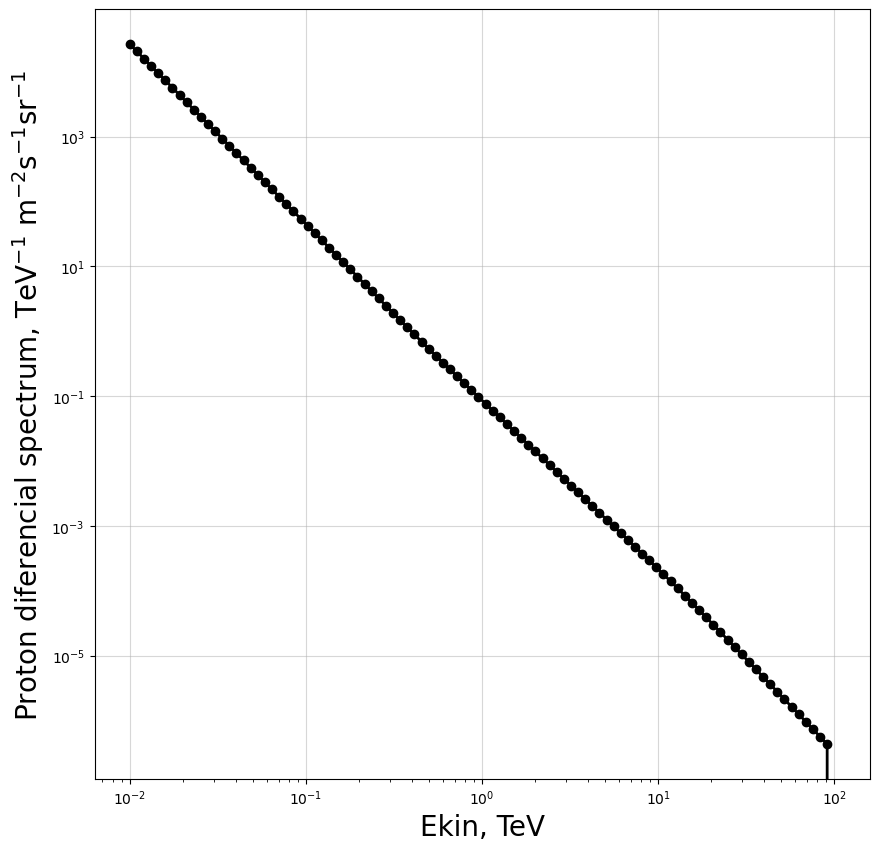

In [3]:
fig, ax = plt.subplots(figsize=(10,10))

thefontsize=20

ax.set_ylabel('Proton diferencial spectrum, TeV$^{-1}$ m$^{-2}$s$^{-1}$sr$^{-1}$',fontsize=thefontsize)
ax.set_xlabel('Ekin, TeV',fontsize=thefontsize)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(-4,6);
#ax.set_ylim(-0.000001,0.000001);
#
ax.grid(True,alpha=0.5)
ekin=np.logspace(np.log10(0.01),np.log10(100.0),100)

ax.plot(ekin, 
        DAMPE_proton(ekin),
        lw=2, 
        color='black', 
        marker='o',
        label='data')

In [4]:
# Import soft DAMPE spectrum (6.3 - 100 TeV) for Protons
#def DAMPE_soft(energy):
#    result = (0.0868*pow(energy, -2.6) * pow((1 + pow((energy/13.6),5.0)), -0.05))
#    if result < 0: result = 0
#    return result

In [5]:
A=np.array([1.0,2.0,3.0])
B=np.int32(A>2.0)
C=np.array([1,2,3])
type(C[0])

numpy.int64

In [6]:
np.power(np.array([1.0,2.0,3.0]),2.0)

array([1., 4., 9.])

In [7]:
ncsvf=!(ls ../scratch/simtel_data/proton/npe/corsika_run*.npe.csv | wc -l)
ncsvf=int((ncsvf[0]))
fname_list=['../scratch/simtel_data/proton/npe/corsika_run' + str(i) + '.npe.csv' for i in range(1,ncsvf+1)]
df_list=[pd.read_csv(fname) for fname in fname_list]
#
df=pd.concat(df_list, ignore_index=True)
n_sim_ev_per_file = 1000000.0
n_sim_ev = len(df_list)*n_sim_ev_per_file
dt_one_wf_ns = 75*1000/1024.0
dt_one_wf_s = dt_one_wf_ns*1.0e-9
#
print("n_sim_ev     = ", n_sim_ev)
print("len(df_list) = ", len(df_list))
print("dt_one_wf_ns = ", dt_one_wf_ns)
print("dt_one_wf_s  = ", dt_one_wf_s)

n_sim_ev     =  426000000.0
len(df_list) =  426
dt_one_wf_ns =  73.2421875
dt_one_wf_s  =  7.324218750000001e-08


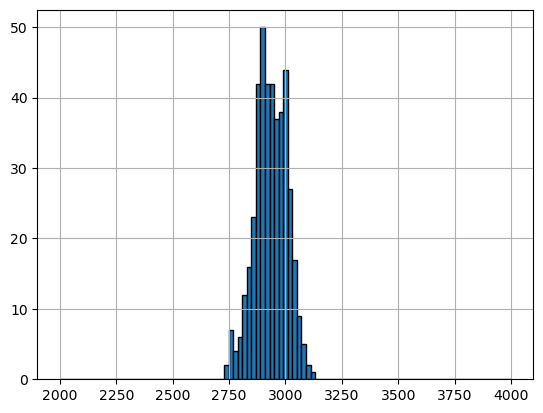

426


In [8]:
plt.hist(np.array([len(dftmp) for dftmp in df_list]), bins=np.linspace(2000.0, 4000, num=100), edgecolor='black', alpha=1.0)
plt.grid(True)
# Show the plot
plt.show()
print(len(df_list))

In [9]:
np.mean(np.array([len(dftmp) for dftmp in df_list]))/n_sim_ev_per_file

0.0029335305164319247

In [10]:
len(df)/len(df_list)

2933.5305164319248

In [11]:
len(df)

1249684

In [12]:
df

,Unnamed: 0,event_id,energy,azimuth,altitude,h_first_int,xmax,hmax,emax,cmax,...,L3_cl_channelID_LST3,L3_cl_timeID_LST3,L3_cl_n_digitalsum_points_LST4,L3_cl_n_clusters_LST4,L3_cl_n_points_LST4,L3_cl_x_mean_LST4,L3_cl_y_mean_LST4,L3_cl_t_mean_LST4,L3_cl_channelID_LST4,L3_cl_timeID_LST4
0,0,5200.0,0.115086,3.062638,1.218684,16199.321289,273.076935,10251.343750,273.333344,278.034241,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0
1,1,5208.0,0.115086,3.062638,1.218684,16199.321289,273.076935,10251.343750,273.333344,278.034241,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0
2,2,5504.0,1.123066,3.220341,1.271500,12663.388672,457.200012,6639.671875,461.428558,460.637756,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0
3,3,6409.0,0.122709,2.996659,1.231897,17323.265625,294.000000,9758.931641,294.000000,328.353088,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0
4,4,7604.0,0.230914,3.106559,1.238464,13307.477539,516.086975,5728.506348,516.956543,458.041138,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1249679,2833,9968301.0,0.655462,3.029138,1.208794,15159.474609,337.500000,8817.290039,334.666656,300.884735,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0
1249680,2834,9972704.0,2.421454,2.814749,1.269003,31757.238281,231.363632,11332.046875,231.333328,226.344101,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0
1249681,2835,9973603.0,0.903230,3.182498,1.352516,17908.154297,354.615387,8472.549805,354.000000,357.879913,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0
1249682,2836,9986905.0,0.249339,3.064357,1.168519,16672.931641,234.000000,11259.129883,233.157898,233.855255,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,-999.0,-999.0,-999.0,-999.0


In [13]:
np.array(df.index)

array([      0,       1,       2, ..., 1249681, 1249682, 1249683])

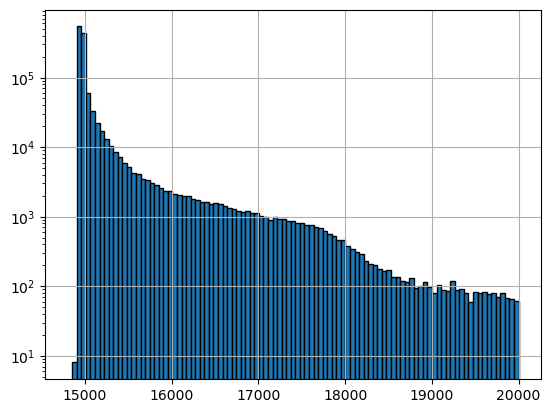

In [14]:
plt.hist(df['L1_max_digi_sum_LST1'].values, bins=np.linspace(14800, 20000, num=100), edgecolor='black', alpha=1.0)
plt.yscale('log')
plt.grid(True)
plt.show()

Text(0, 0.5, '')

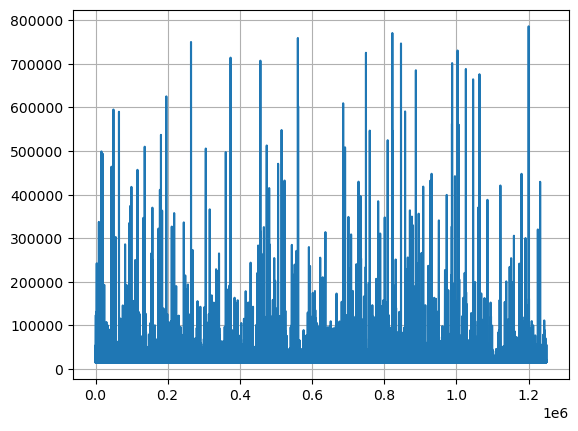

In [15]:
plt.grid(True)
plt.plot(np.array(df.index[:]),df['L1_max_digi_sum_LST1'].values[:],alpha=1)
plt.grid(True)
#plt.ylim(17000.0, 19000.0)
plt.ylabel('')

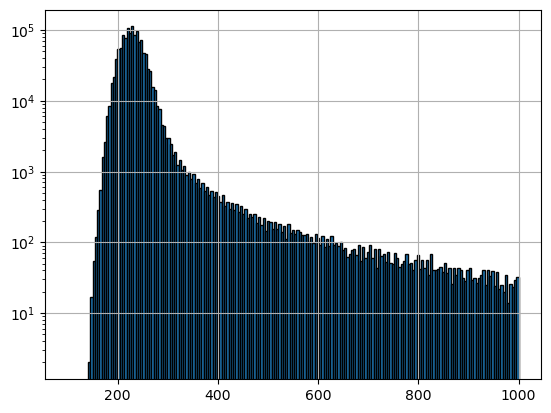

In [16]:
plt.hist(df['L3_iso_n_digitalsum_points_LST1'].values, bins=np.linspace(100, 1000, num=200), edgecolor='black', alpha=1.0)
plt.yscale('log')
plt.grid(True)
plt.show()

In [17]:
df_20pe_DCR=df[df['n_pe_LST1']==20]
df_min20pe=df[df['n_pe_LST1']>=20]
df_min30pe=df[df['n_pe_LST1']>=30]
df_min40pe=df[df['n_pe_LST1']>=40]
df_min50pe=df[df['n_pe_LST1']>=50]
df_min60pe=df[df['n_pe_LST1']>=60]
df_min70pe=df[df['n_pe_LST1']>=70]
df_min80pe=df[df['n_pe_LST1']>=80]
df_min90pe=df[df['n_pe_LST1']>=90]
df_min100pe=df[df['n_pe_LST1']>=100]
df_min110pe=df[df['n_pe_LST1']>=110]

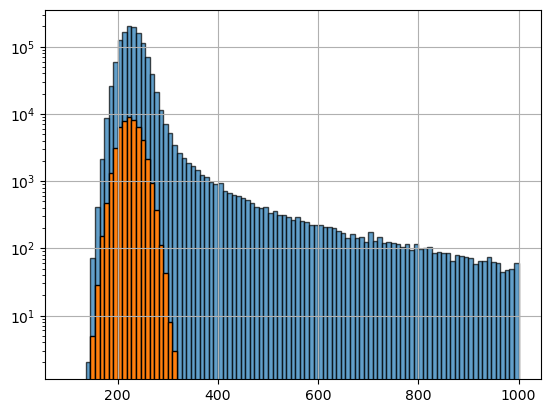

In [18]:
plt.hist(df['L3_iso_n_digitalsum_points_LST1'].values, bins=np.linspace(100, 1000, num=100), edgecolor='black', alpha=0.7)
plt.hist(df_20pe_DCR['L3_iso_n_digitalsum_points_LST1'].values, bins=np.linspace(100, 1000, num=100), edgecolor='black', alpha=1.0)
plt.yscale('log')
plt.grid(True)
plt.show()

In [19]:
np.mean(df_20pe_DCR['L3_iso_n_digitalsum_points_LST1'].values)/dt_one_wf_s/1.0e+9

3.068753506001263

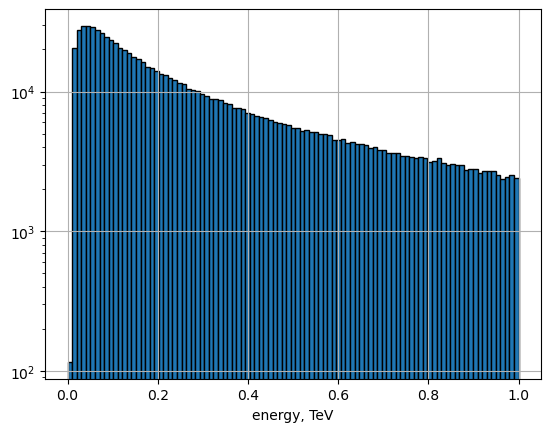

In [20]:
plt.hist(df['energy'].values, bins=np.linspace(0.0, 1.0, num=100), edgecolor='black', alpha=1.0)
plt.xlabel('energy, TeV')
#plt.ylabel('')
#plt.title('energy')
plt.yscale('log')
plt.grid(True)
plt.show()

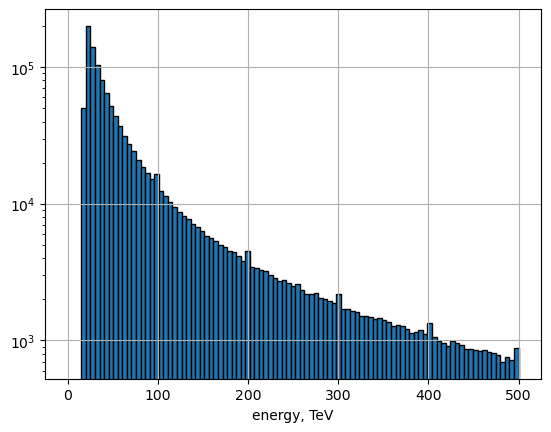

In [21]:
plt.hist(df['n_pe_LST1'].values, bins=np.linspace(0, 500, num=100), edgecolor='black', alpha=1.0)
plt.xlabel('energy, TeV')
#plt.ylabel('')
#plt.title('energy')
plt.yscale('log')
plt.grid(True)
plt.show()

In [22]:
#14963 and L3 n points is > 7
df_trg_l1=df[df['L1_max_digi_sum_LST1']>14963]
df_trg_l2=df_trg_l1[df_trg_l1['L3_iso_n_points_LST1']>7]

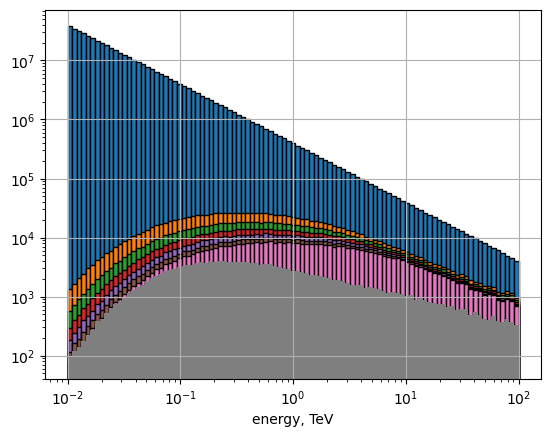

In [23]:
hist_sim=plt.hist(1.0/np.random.uniform(1.0/100,1.0/0.01,int(n_sim_ev)), 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
hist_trg20pe=plt.hist(df_min20pe['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
hist_trg30pe=plt.hist(df_min30pe['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
hist_trg40pe=plt.hist(df_min40pe['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
hist_trg50pe=plt.hist(df_min50pe['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
hist_trg60pe=plt.hist(df_min60pe['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
hist_trg70pe=plt.hist(df_min70pe['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
#
hist_trg=plt.hist(df_trg_l2['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), alpha=1.0)
#
plt.xlabel('energy, TeV')
plt.yscale('log')
plt.xscale('log')
plt.grid(True)
plt.show()

In [24]:
df_LSTsipm_protons_sim = pd.DataFrame({
    'energy': (hist_sim[1][:-1] + hist_sim[1][1:])/2.0,
    'nev': hist_sim[0]
})
df_LSTsipm_protons_trg = pd.DataFrame({
    'energy': (hist_trg[1][:-1] + hist_trg[1][1:])/2.0,
    'nev': hist_trg[0]
})
#
#
#df_LSTsipm_protons_sim.to_csv('LST_AdvCam_Zenith_20.00deg_proton_sim.csv', index=False, header=False, sep=' ')
#df_LSTsipm_protons_trg.to_csv('LST_AdvCam_Zenith_20.00deg_proton_trg.csv', index=False, header=False, sep=' ')
#df_LSTsipm_protons_trg['nev'].values/df_LSTsipm_protons_sim['nev'].values

7263.327967768678


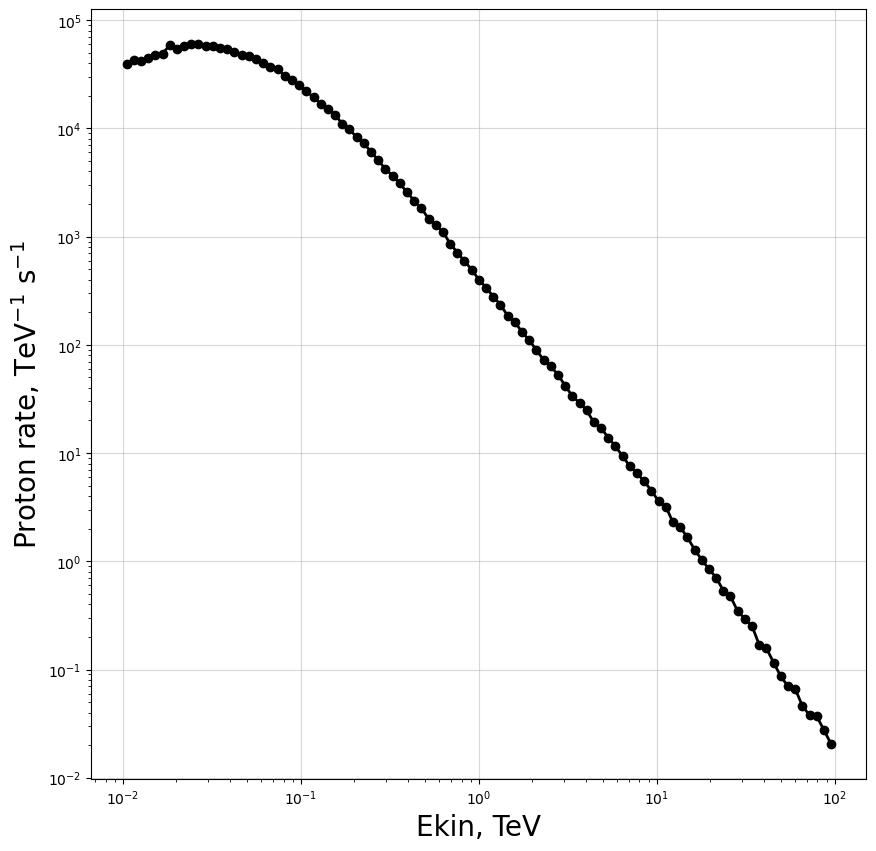

In [25]:
fig, ax = plt.subplots(figsize=(10,10))

thefontsize=20

ax.set_ylabel('Proton rate, TeV$^{-1}$ s$^{-1}$',fontsize=thefontsize)
ax.set_xlabel('Ekin, TeV',fontsize=thefontsize)
ax.set_xscale('log')
ax.set_yscale('log')
#ax.set_xlim(-4,6);
#ax.set_ylim(-0.000001,0.000001);
#
ax.grid(True,alpha=0.5)
ekin=df_LSTsipm_protons_sim['energy'].values
rate_per_TeV_per_s=DAMPE_proton(ekin)*df_LSTsipm_protons_trg['nev'].values/df_LSTsipm_protons_sim['nev'].values*np.pi*1500*1500*get_solid_angle(10)

ax.plot(ekin, 
        rate_per_TeV_per_s,
        lw=2, 
        color='black', 
        marker='o',
        label='data')

print(get_integral( ekin, rate_per_TeV_per_s, 0.01, 100))

#print("nterp ",np.interp([10,20], ekin, rate_per_TeV_per_s))

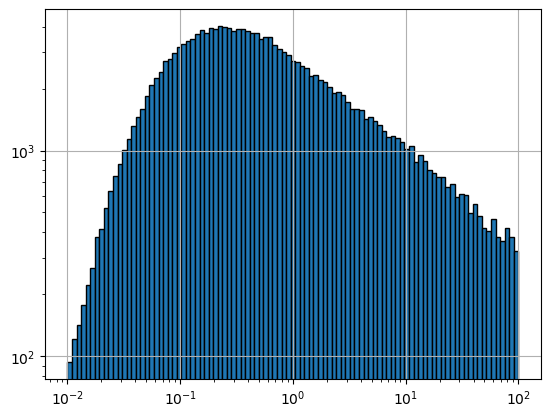

In [26]:
#
hist_trg=plt.hist(df_trg_l2['energy'].values, 
         bins=np.logspace(np.log10(0.01),np.log10(100),100), edgecolor='black', alpha=1.0)
#
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.show()
#

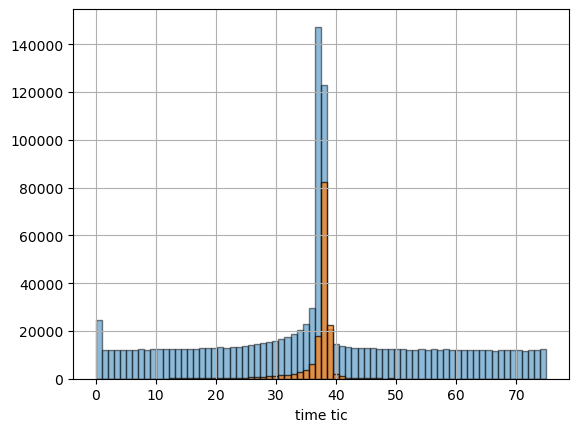

In [27]:
plt.hist(df['L1_t_mean_LST1'].values, bins=np.linspace(0.0, 75, num=75), edgecolor='black', alpha=0.5)
plt.hist(df_trg_l2['L3_cl_t_mean_LST1'].values*1.0/0.06, bins=np.linspace(0.0, 75, num=75), edgecolor='black', alpha=0.7)
plt.xlabel('time tic')
#plt.yscale('log')
plt.grid(True)
plt.show()

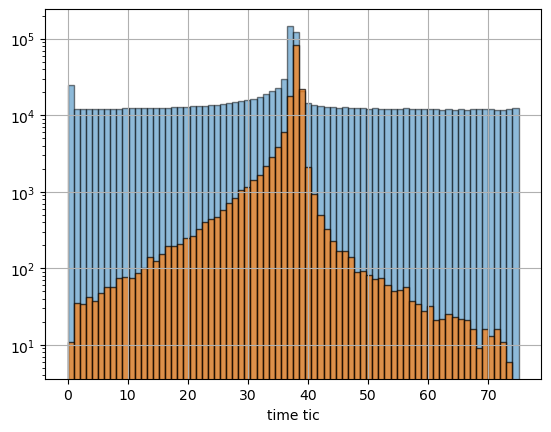

In [28]:
plt.hist(df['L1_t_mean_LST1'].values, bins=np.linspace(0.0, 75, num=75), edgecolor='black', alpha=0.5)
plt.hist(df_trg_l2['L3_cl_t_mean_LST1'].values*1.0/0.06, bins=np.linspace(0.0, 75, num=75), edgecolor='black', alpha=0.7)
plt.xlabel('time tic')
plt.yscale('log')
plt.grid(True)
plt.show()

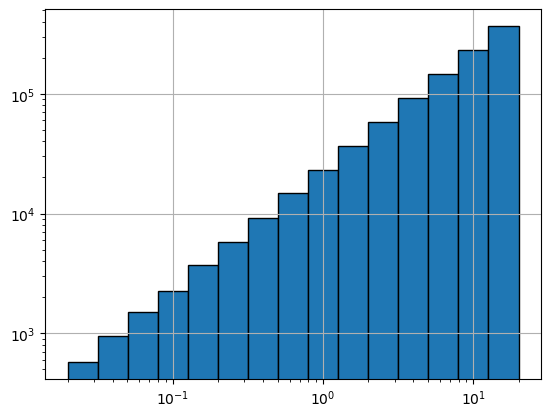

In [29]:
thehist=plt.hist(np.random.uniform(0.02,20,1000000), bins=np.logspace(np.log10(0.02),np.log10(20.0),16), edgecolor='black', alpha=1.0)
#plt.hist(np.random.uniform(0.02,20,10000), bins=np.linspace(0.02,20,16), edgecolor='black', alpha=1.0)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xscale('log')  # Set y-axis to logarithmic scale
plt.grid(True)
plt.show()

In [30]:
thehist

(array([   576.,    943.,   1506.,   2271.,   3714.,   5785.,   9144.,
         14818.,  23303.,  36765.,  58484.,  93101., 146945., 233089.,
        369556.]),
 array([ 0.02      ,  0.03169786,  0.05023773,  0.07962143,  0.12619147,
         0.2       ,  0.31697864,  0.50237729,  0.79621434,  1.26191469,
         2.        ,  3.16978638,  5.02377286,  7.96214341, 12.61914689,
        20.        ]),
 <BarContainer object of 15 artists>)

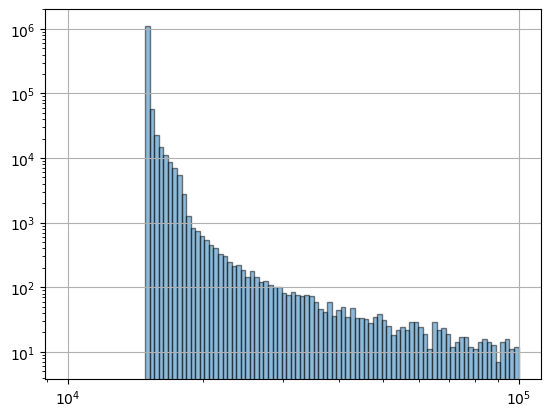

In [31]:
plt.hist(df['L1_max_digi_sum_LST1'].values, bins=np.logspace(np.log10(10000),np.log10(100000.0),100), edgecolor='black', alpha=0.5)
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xscale('log')  # Set y-axis to logarithmic scale
plt.grid(True)
plt.show()

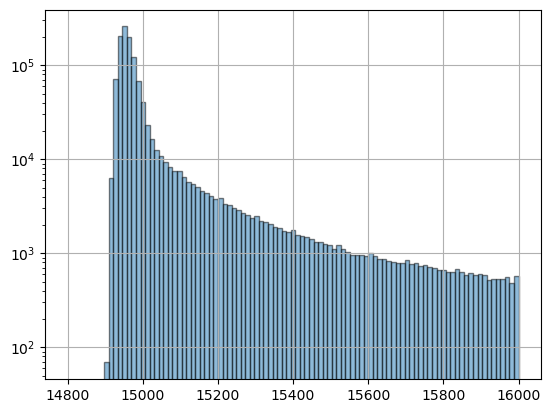

In [32]:
plt.hist(df['L1_max_digi_sum_LST1'].values, bins=np.linspace(14800,16000,100), edgecolor='black', alpha=0.5)
plt.yscale('log')   # Set y-axis to logarithmic scale
#plt.xscale('log')  # Set y-axis to logarithmic scale
plt.grid(True)
plt.show()

In [33]:
len(df['L1_max_digi_sum_LST1'])

1249684

In [34]:
np.linspace(0,1,10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])